# Customer Retention

The purpose of this project is to determine if there is a model that can determine what factors may lead to a customer leaving a bank service, using customer behavior as a predictive metric. We will build a model that aims to maximize F1 score, with a minimum of 0.59. Additionally, we will compare the AUC-ROC with this F1 score.

## Initialization

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# for data prep

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# for model creation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# for model checking

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [46]:
# import data

data = pd.read_csv('/datasets/Churn.csv')

In [47]:
# examine data

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


A couple of things to do before we work with the data. We could rename the columns if we wanted to, but due to the format we would need to manually rename them, so we will not do that. What we should try and figure out, then, is the missing values in the "tenure" column.

According to our dataset, the tenure value is the period of maturation for a fixed deposit. The null values likely are for people who do not have tenure, whereas values of 0 are ones where they have a newly acquired one. For the purposes of analysis, it should be fine to fill out null values in the tenure column with 0.

In [49]:
# fill null values

data['Tenure'] = data['Tenure'].fillna(0)

Before we work on the data preparation, let's also take a look at the balance of our target classes.

In [50]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

About 80% of our users have not exited. We will need to take this in mind and investigate the imbalance later.

### Data preparation

Next, we should identify our features and target. We know that our target is the "Exited" column. The features, then are ones that we should choose to be as relevant as possible.

Row number and surname are both somewhat arbitrary identifiers so they are probably not necessary to keep. CustomerID, however, could be a relevant predictor. If, for instance, there are a large amount of customers who signed up in a period who have all exited, that might indicate something. It is unlikely to result in being relevant, but should not cause much issue leaving it in. All the other features are also likely predictors.


In [51]:
# create target and features

target = data['Exited']
features = data.drop(['RowNumber', 'Surname', 'Exited'], axis = 1)

Before we split into training, validation, and test set (we will use 60% of the data to the training set, with 20% for a validation set and 20% for test set) now would be a good time to make our features into numeric dummy variables.

There are two non-numeric columns: country and gender. The data only contains three countries: Germany, Spain and France. Thus, in both of these columns we can drop one of them to prevent the dummies from influencing our model more than necessary.

In [52]:
# create dummies

features_ohe = pd.get_dummies(features, drop_first=True)

In [53]:
# split into training and test set

features_train, features_test, target_train, target_test = train_test_split(features_ohe, target,
    test_size=0.20, shuffle = True, random_state = 8)

# split the training set into a validation set

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
    test_size=0.25, random_state= 8)

In [54]:
# print the size of each set

print("Features training:", features_train.shape)
print("Target training:", target_train.shape, "\n")

print("Features validation:", features_valid.shape)
print("Target validation:", target_valid.shape, "\n")

print("Features test:", features_test.shape)
print("Target test:", target_test.shape)

Features training: (6000, 12)
Target training: (6000,) 

Features validation: (2000, 12)
Target validation: (2000,) 

Features test: (2000, 12)
Target test: (2000,)


There also are different scales for our numerical variables, which likely will result in errors of the model's judgment. Before we build a model, we should deal with that.

In [55]:
# scale numeric variables

numeric = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_76/1664466759.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


## Model Test

First, we should look at our options between a decision tree, random forest, or logistic model to get our prediction.

We also will initialize a single function that prints out a variety of the metrics we're interested in seeing. We will likely want to see each of them for multiple models, so making them a single function will clean up our code.

In [56]:
# model checking function

def model_metrics(target, predicted):
    print("Accuracy:", accuracy_score(target, predicted))
    print("Recall:", recall_score(target, predicted))
    print("Precision:", precision_score(target, predicted))
    print("F1:", f1_score(target, predicted))
    print("Confusion Matrix:\n", confusion_matrix(target, predicted))

In [57]:
# decision tree

model = DecisionTreeClassifier(random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.7945
Recall: 0.5125628140703518
Precision: 0.4845605700712589
F1: 0.4981684981684981
Confusion Matrix:
 [[1385  217]
 [ 194  204]]


In [58]:
# random forest

model = RandomForestClassifier(random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.862
Recall: 0.4648241206030151
Precision: 0.7459677419354839
F1: 0.5727554179566563
Confusion Matrix:
 [[1539   63]
 [ 213  185]]


In [59]:
# logistic regression

model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8155
Recall: 0.21608040201005024
Precision: 0.6013986013986014
F1: 0.31792975970425136
Confusion Matrix:
 [[1545   57]
 [ 312   86]]


Just for a quick test, we performed a really simple decision tree and random forest classifier, as a means to get a benchmark on the model without tuning any sort of complicated factors. We have scores below our desired threshold for all of our metrics. From our confusion matrices, we see that there seems to be a higher likelihood of finding a false negative, possibly because most of our data are negative results.

The random forest classifier seems like it is far more likely to influence the model, with it having a wide swing causing high precision, but the F1 score did not noticeably change. It's very close to our desired 0.59 result already. We can see that the random forest is more likely to result in false negatives, and the decision tree model is more skewed towards false positives.

Overall, the random forest model shows the most promise, with the highest level of accuracy, as well as the most clear path on what we should do, since there are very few false positives in that model. Thus, for the remainder of the project we will focus on the random forest.

To get an idea of the model on a basic level, we will also create a simple PR curve.

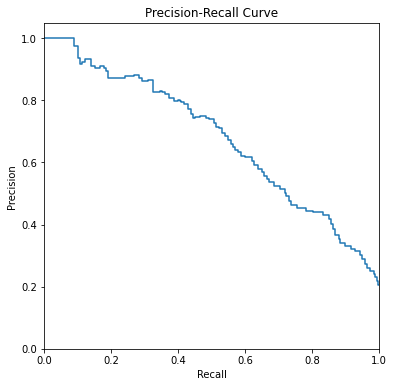

In [60]:
# set model to random forest

model = RandomForestClassifier(random_state = 12345)
model.fit(features_train, target_train)

# check PR curve

probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 

Not that we were expecting amazing results from such a simple model, but this curve does seem to show that the model is already looking pretty good. We can try to make it even more robust, which is necessary as the random forest did not give us our desired F1 score.

## Model improvement

Seeing the results from the Random Forest model shows that will likely be our best choice for this problem. Now we need to tweak the model to get our desired accuracy.

It seems that balancing our class weight did not have much impact on our data. It is slightly more accurate (0.001 more) but the recall is lower and so that causes the F1 score to be lower than leaving them unbalanced.

We can also try tuning some hyperparameters and see what impact that has on pushing our F1 score up. We will start by seeing a minimum sample split tuning. However, before we do anything involving tuning our model, we should try and get our data in the most useful state it can be.

In [61]:
# create upsample function

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state = 12345
    )

    return features_upsampled, target_upsampled

# upsample data

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

# create upsampled model

model = RandomForestClassifier(random_state = 12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8515
Recall: 0.5150753768844221
Precision: 0.6634304207119741
F1: 0.5799151343705798
Confusion Matrix:
 [[1498  104]
 [ 193  205]]


In [62]:
# create downsample function

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state = 12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state = 12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state = 12345
    )

    return features_downsampled, target_downsampled

# downsample data

features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

# create downsampled model

model = RandomForestClassifier(random_state = 12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.5535
Recall: 0.9472361809045227
Precision: 0.3018414731785428
F1: 0.4578020643594414
Confusion Matrix:
 [[730 872]
 [ 21 377]]


The upsampling is very promising. It increased our F1 slightly by simply going to 10 observations. In comparison, the downsampling, while it did reduce the issue with our false negatives, also ended up dramatically raising our false positives so our F1 score took a massive hit. It seems that upsampling is the way to go.

Firstly, we can aim to get a larger upsample as that will lead to am improvement in our F1 score, but it will have diminishing returns and if we perform too many upsamples then it could become counterproductive.

In [63]:
# set model using upsampled data

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 100
)

model = RandomForestClassifier(random_state = 12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8425
Recall: 0.4899497487437186
Precision: 0.6351791530944625
F1: 0.5531914893617021
Confusion Matrix:
 [[1490  112]
 [ 203  195]]


Our 10 upsamples did reduce our precision more than they increased our recall. As we take more upsamples we lose precision faster than we gain recall. We will stick to upsampling just 10 times.

In [64]:
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

Next, we might wish to look at adjusting our thresholds.

In [65]:
# check threshold adjustments

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}'.format(
                threshold, precision, recall, f1))

Threshold = 0.00 | Precision = 0.208, Recall = 0.997, F1 = 0.344
Threshold = 0.02 | Precision = 0.231, Recall = 0.992, F1 = 0.375
Threshold = 0.04 | Precision = 0.256, Recall = 0.982, F1 = 0.406
Threshold = 0.06 | Precision = 0.279, Recall = 0.970, F1 = 0.433
Threshold = 0.08 | Precision = 0.301, Recall = 0.962, F1 = 0.458
Threshold = 0.10 | Precision = 0.318, Recall = 0.935, F1 = 0.474
Threshold = 0.12 | Precision = 0.337, Recall = 0.915, F1 = 0.492
Threshold = 0.14 | Precision = 0.349, Recall = 0.884, F1 = 0.501
Threshold = 0.16 | Precision = 0.365, Recall = 0.859, F1 = 0.512
Threshold = 0.18 | Precision = 0.381, Recall = 0.837, F1 = 0.524
Threshold = 0.20 | Precision = 0.398, Recall = 0.819, F1 = 0.535
Threshold = 0.22 | Precision = 0.418, Recall = 0.799, F1 = 0.549
Threshold = 0.24 | Precision = 0.435, Recall = 0.779, F1 = 0.559
Threshold = 0.26 | Precision = 0.457, Recall = 0.759, F1 = 0.570
Threshold = 0.28 | Precision = 0.473, Recall = 0.731, F1 = 0.575
Threshold = 0.30 | Precis

We can see here that raising our threshold does slowly raise our F1 score, as the recall and precision become more balanced. In between a threshold of 0.36, we see a maximized F1 score of 0.598 - this is actually good enough for our objective. We also see that it will be maximized at that point, as once we pass it, our recall drops and the F1 score begins to decline.

In [66]:
# set predictions with the threshold

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.4

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8345
Recall: 0.6005025125628141
Precision: 0.5815085158150851
F1: 0.5908529048207664
Confusion Matrix:
 [[1430  172]
 [ 159  239]]


To get a handle on how well our model is doing, let's make a ROC curve to find out our false positive rate.

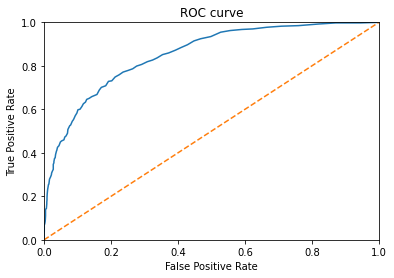

In [67]:
# create auc_roc score

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

# create plot

plt.figure()
plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)

plt.plot([0, 1], [0, 1], linestyle='--')

# set axes

plt.xlim([0, 1])
plt.ylim([0, 1])

# label graph

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# display graph

plt.show()

We receive a pretty steep curve here. It's a sign that our model is looking quite good. Based on the curvature, it seems like it might start to become more difficult to achieve significantly greater results than the model we have right now. However, we can still give it a shot, by seeing what happens if we tune our hyperparameters.

## Parameter tuning

Since there are many more 0 observations on our "Exited" column than there are 1s, the first thing to consider would be what results we would get balancing the classes.

In [68]:
# balanced classes

balance_model = RandomForestClassifier(class_weight = 'balanced', random_state = 12345)
balance_model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8425
Recall: 0.4899497487437186
Precision: 0.6351791530944625
F1: 0.5531914893617021
Confusion Matrix:
 [[1490  112]
 [ 203  195]]


Balancing our classes slightly improves our accuracy, but the tradeoff is that our recall has dropped too much and as a result, the F1 score is lower.

In [69]:
# create lists to store our values

ms_f1 = []

# create a loop

for depth in range(2,100):
    # create model
    
    sample_model = RandomForestClassifier(random_state=12345, min_samples_split=depth)
    sample_model.fit(features_upsampled, target_upsampled)
    
    # predict value
    
    predicted_valid = sample_model.predict(features_valid)
    
    # store prediction's f1 score
    
    training_score =  f1_score(target_valid, predicted_valid)
    ms_f1.append(training_score)

    # print results
    
    print("min samples =", depth, ": \n")

    model_metrics(target_valid, predicted_valid)

min samples = 2 : 

Accuracy: 0.8515
Recall: 0.5150753768844221
Precision: 0.6634304207119741
F1: 0.5799151343705798
Confusion Matrix:
 [[1498  104]
 [ 193  205]]
min samples = 3 : 

Accuracy: 0.85
Recall: 0.5201005025125628
Precision: 0.6550632911392406
F1: 0.5798319327731092
Confusion Matrix:
 [[1493  109]
 [ 191  207]]
min samples = 4 : 

Accuracy: 0.851
Recall: 0.5226130653266332
Precision: 0.6582278481012658
F1: 0.5826330532212886
Confusion Matrix:
 [[1494  108]
 [ 190  208]]
min samples = 5 : 

Accuracy: 0.8465
Recall: 0.5025125628140703
Precision: 0.6472491909385113
F1: 0.5657708628005658
Confusion Matrix:
 [[1493  109]
 [ 198  200]]
min samples = 6 : 

Accuracy: 0.8485
Recall: 0.5326633165829145
Precision: 0.6443768996960486
F1: 0.5832187070151307
Confusion Matrix:
 [[1485  117]
 [ 186  212]]
min samples = 7 : 

Accuracy: 0.85
Recall: 0.542713567839196
Precision: 0.6467065868263473
F1: 0.5901639344262296
Confusion Matrix:
 [[1484  118]
 [ 182  216]]
min samples = 8 : 

Accuracy

In [70]:
# find maximum accuracy

print("Depth of F1 maximum:", ms_f1.index(max(ms_f1))+1,
      "\nTraining set maximum:", max(ms_f1))

Depth of F1 maximum: 25 
Training set maximum: 0.6097297297297298


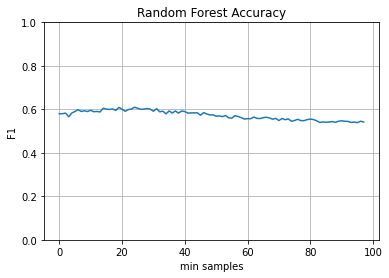

In [71]:
plt.plot(ms_f1)

# plot details

plt.ylabel('F1')
plt.xlabel('min samples')
plt.title("Random Forest Accuracy")
plt.ylim(0,1)
plt.grid()
plt.show()

While tuning the number of minimum samples does seem to have an effect on our model's overall F1 score, it is definitely not doing so in a major way. If anything, we see a steady decrease in the overall F1 score as we make our samples require more minimum values. While our F1 score is "maximized" at higher than the default (at 10 minimum samples to split), it is not in any sort of pattern and thus we will ignore this hyperparameter and continue with using a default.

We will also try tuning our model's maximum depth.

In [72]:
# create lists to store our values

md_f1 = []

# create a loop

for depth in range(1,51):
    # create model
    
    depth_model = RandomForestClassifier(random_state=12345, max_depth=depth)
    depth_model.fit(features_upsampled, target_upsampled)
    
    # predict value
    
    predicted_valid = depth_model.predict(features_valid)
    
    # store prediction's f1 score
    
    training_score =  f1_score(target_valid, predicted_valid)
    md_f1.append(training_score)

    # print results
    
    print("max depth =", depth, ": \n")

    model_metrics(target_valid, predicted_valid)

max depth = 1 : 

Accuracy: 0.199
Recall: 1.0
Precision: 0.199
F1: 0.33194328607172646
Confusion Matrix:
 [[   0 1602]
 [   0  398]]
max depth = 2 : 

Accuracy: 0.201
Recall: 1.0
Precision: 0.19939879759519039
F1: 0.3324979114452799
Confusion Matrix:
 [[   4 1598]
 [   0  398]]
max depth = 3 : 

Accuracy: 0.3705
Recall: 0.9874371859296482
Precision: 0.23861566484517305
F1: 0.38435207823960876
Confusion Matrix:
 [[ 348 1254]
 [   5  393]]
max depth = 4 : 

Accuracy: 0.4045
Recall: 0.9824120603015075
Precision: 0.24825396825396825
F1: 0.39635073492143946
Confusion Matrix:
 [[ 418 1184]
 [   7  391]]
max depth = 5 : 

Accuracy: 0.473
Recall: 0.9723618090452262
Precision: 0.27062937062937065
F1: 0.4234135667396061
Confusion Matrix:
 [[ 559 1043]
 [  11  387]]
max depth = 6 : 

Accuracy: 0.551
Recall: 0.964824120603015
Precision: 0.3028391167192429
F1: 0.46098439375750294
Confusion Matrix:
 [[718 884]
 [ 14 384]]
max depth = 7 : 

Accuracy: 0.5935
Recall: 0.957286432160804
Precision: 0.3237

In [73]:
# find maximum accuracy

print("Depth of F1 maximum:", md_f1.index(max(md_f1))+1,
      "\nTraining set maximum:", max(md_f1))

Depth of F1 maximum: 14 
Training set maximum: 0.5952941176470589


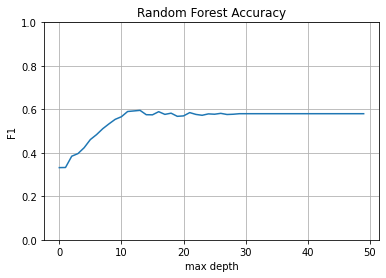

In [74]:
plt.plot(md_f1)

# plot details

plt.ylabel('F1')
plt.xlabel('max depth')
plt.title("Random Forest Accuracy")
plt.ylim(0,1)
plt.grid()
plt.show()

This maximum depth modification model is not providing improvement, even as it approaches its peak. We will not pursue it, here. We will try a minimum samples leaf.

In [75]:
# create lists to store our values

leaf_f1 = []

# create a loop

for depth in range(1,101):
    # create model
    
    leaf_model = RandomForestClassifier(random_state=12345, min_samples_leaf=depth)
    leaf_model.fit(features_upsampled, target_upsampled)
    
    # predict value
    
    predicted_valid = leaf_model.predict(features_valid)
    
    # store prediction's f1 score
    
    training_score =  f1_score(target_valid, predicted_valid)
    leaf_f1.append(training_score)

    # print results
    
    print("min samples leaf =", depth, ": \n")

    model_metrics(target_valid, predicted_valid)

min samples leaf = 1 : 

Accuracy: 0.8515
Recall: 0.5150753768844221
Precision: 0.6634304207119741
F1: 0.5799151343705798
Confusion Matrix:
 [[1498  104]
 [ 193  205]]
min samples leaf = 2 : 

Accuracy: 0.837
Recall: 0.6030150753768844
Precision: 0.5882352941176471
F1: 0.5955334987593052
Confusion Matrix:
 [[1434  168]
 [ 158  240]]
min samples leaf = 3 : 

Accuracy: 0.828
Recall: 0.6608040201005025
Precision: 0.5572033898305084
F1: 0.6045977011494252
Confusion Matrix:
 [[1393  209]
 [ 135  263]]
min samples leaf = 4 : 

Accuracy: 0.816
Recall: 0.6984924623115578
Precision: 0.5285171102661597
F1: 0.6017316017316017
Confusion Matrix:
 [[1354  248]
 [ 120  278]]
min samples leaf = 5 : 

Accuracy: 0.8145
Recall: 0.7638190954773869
Precision: 0.5232358003442341
F1: 0.6210418794688458
Confusion Matrix:
 [[1325  277]
 [  94  304]]
min samples leaf = 6 : 

Accuracy: 0.794
Recall: 0.7587939698492462
Precision: 0.4886731391585761
F1: 0.594488188976378
Confusion Matrix:
 [[1286  316]
 [  96  302

In [76]:
# find maximum accuracy

print("Min samples leaf maximum:", leaf_f1.index(max(leaf_f1))+1,
      "\nTraining set maximum:", max(leaf_f1))

Min samples leaf maximum: 5 
Training set maximum: 0.6210418794688458


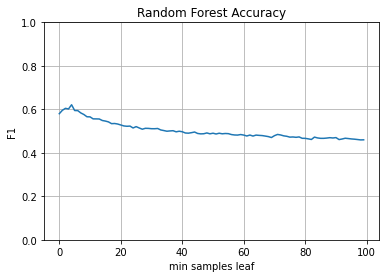

In [77]:
plt.plot(leaf_f1)

# plot details

plt.ylabel('F1')
plt.xlabel('min samples leaf')
plt.title("Random Forest Accuracy")
plt.ylim(0,1)
plt.grid()
plt.show()

In [78]:
# leaf model

model = RandomForestClassifier(random_state=12345, min_samples_leaf=5)
model.fit(features_upsampled, target_upsampled)
    
# predict value
    
predicted_valid = model.predict(features_valid)

model_metrics(target_valid, predicted_valid)

Accuracy: 0.8145
Recall: 0.7638190954773869
Precision: 0.5232358003442341
F1: 0.6210418794688458
Confusion Matrix:
 [[1325  277]
 [  94  304]]


It seems like adjusting our minimum samples leaf value has some sort of effect that makes a curve that does not appear to be random. It quickly drops but when we split by leaves of minimum size 5, we will end up getting a model that is overall better. The precision dropped, but the recall grew at a faster rate. There are some ways that this model could be considered inferior, since it results in more false positives.

In this instance, we should choose between the min samples model and the threshold model based on our goal. The aim of our predictive model is to identify which customers are likely to leave so that we can aim to retain their services. There will be relatively fewer consequences if the model returns a false positive - so long as it is not returning too many positives. However, each time we return a false negative, that is an extra customer lost. When our goal is to keep as many customers as possible, we should probably err on the side of our higher F1 model even if it is more likely to give us a false positive.

## Model testing

Finally, we should test the model that we decided was our best fit with the test set.

In [79]:
# leaf model

model = RandomForestClassifier(random_state=12345, min_samples_leaf=5)
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test)

model_metrics(target_test, predicted_test)

Accuracy: 0.813
Recall: 0.738498789346247
Precision: 0.5341506129597198
F1: 0.6199186991869919
Confusion Matrix:
 [[1321  266]
 [ 108  305]]


This is a little troublesome. Using our leaf model our F1 score has dipped below the threshold we were looking for, and the reason is specifically because it is too likely to return a false positive. Tweaking the leaf model might get us past that threshold, but with the issue being the imbalance of the model, it might end up being too unreliable.

Instead, let's at least give a look at the thresholded model - the one that also had our validation set return an F1 above 0.59 but that had its recall and precision be more similar to one another.

In [80]:
# threshold model

model = RandomForestClassifier(random_state = 12345)
model.fit(features_upsampled, target_upsampled)

# set predictions with the threshold

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.4

model_metrics(target_test, predicted_test)

Accuracy: 0.8475
Recall: 0.6440677966101694
Precision: 0.6273584905660378
F1: 0.6356033452807647
Confusion Matrix:
 [[1429  158]
 [ 147  266]]


Here we see the highest F1 score yet, which seems to say that the threshold model is working better. Our recall and precision are relatively close. It would seem to suggest that this model will work more reliably with newer data, and we also have a much more stable idea of what proportion of our model will be erroneous. With that in mind, this should probably be our final model.

## Conclusion

In order to achieve our desired F1 score of over 0.59, we first tested a few of our models to see which style would prove the most promising and chose to use a random forest classifier. We checked our models for accuracy, recall, precision, and their F1 scores as we tuned them, modifying by testing for upsampling, downsampling, and altering the classification threshold. We found a model that has a high ROC curve and the suitable F1 score.

We tuned our hyperparameters to find the highest F1 score we could, but identified that it might not be better than one of our earlier models since it was not strictly more accurate but rather was more likely to catch the true positives. When we used our test set, this proved to be true, as the one that did not modify hyperparameters was ultimately a better fitted model.